In [ ]:
# 2. 정규표현식으로 해시태그를 제거해서 전처리 하는 것 보단 해시태그를 이용한 분석을 하는 것도 좋다고 생각함

In [1]:
import os
import re
import platform

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

from datetime import datetime
from tqdm import tqdm
from collections import Counter
import swifter
from konlpy.tag import Kkma, Komoran, Okt, Mecab
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

In [2]:
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
def Fontmanager():

    plt.rcParams['axes.unicode_minus'] = False

    if platform.system() == 'Windows':
        path = "c:/Windows/Fonts/malgun.ttf"
        font_name = font_manager.FontProperties(fname=path).get_name()
        rc('font', family=font_name)
    elif platform.system() == 'Darwin':
        path = '/Library/Fonts/Arial Unicode.ttf'
        font_name = font_manager.FontProperties(fname=path).get_name()
        rc('font', family='AppleGothic')
    elif platform.system() == 'Linux':
        path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
        font_name = font_manager.FontProperties(fname=path).get_name()
        rc('font', family='NanumBarunGothic')
    else:
        print('Unknown system... sorry~~~~~~')
    print(f"해당 pc의 운영 체제는 {platform.system()}이며 {font_name}로 설정되었습니다")  
    return path

In [4]:
path = Fontmanager()

해당 pc의 운영 체제는 Darwin이며 Arial Unicode MS로 설정되었습니다


In [5]:
women_policy = pd.read_csv('dataset/women_policy_labelword.csv')
# 혹시 모를 중복제거
women_policy = women_policy.drop_duplicates()

In [6]:
# 혹시 모를 nan값 확인
women_policy.isna().sum()

datetime      0
id            0
text          0
username      0
tokenized     0
label         0
score         0
label_word    0
dtype: int64

In [7]:
texts = women_policy[women_policy['text'].apply(lambda x : x.startswith('#'))]

In [8]:
texts['text'] = texts['text'].str.split('\n').apply(lambda x : [i for i in x if i.startswith('#') ])
texts['text'] = texts['text'].apply(lambda x: ' '.join(x))
texts['text'] = texts['text'].str.split(' ').apply(lambda x : [i for i in x if i.startswith('#') ])

<ipython-input-8-6b3ef2c31a36>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts['text'] = texts['text'].str.split('\n').apply(lambda x : [i for i in x if i.startswith('#') ])
<ipython-input-8-6b3ef2c31a36>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts['text'] = texts['text'].apply(lambda x: ' '.join(x))
<ipython-input-8-6b3ef2c31a36>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [9]:
word_of_Bag = sum(texts['text'], [])

No handles with labels found to put in legend.


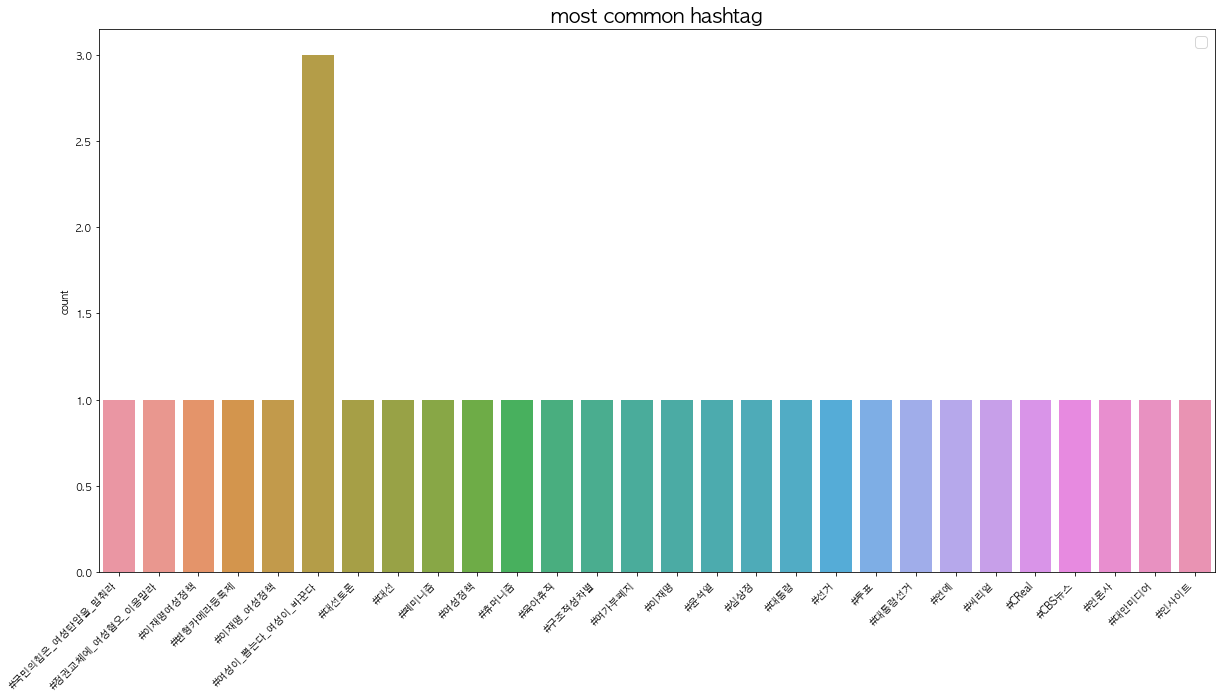

In [10]:
# 해시태그
plt.figure(figsize=(20,10))
plot = sns.countplot(word_of_Bag)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('most common hashtag', fontsize=20)
plt.legend(fontsize=15)
# save_fig('most common hashtag')

In [11]:
# 정규표현식 이용한 전처리
def clean(text):
    #\n 공백 제거
    text = re.sub('\n',' ',str(text))
    # URL 제거
    text = re.sub('https://[A-Za-z0-9./]*','',str(text))
    # 한글자 제거 (ex:ㅋㅋ, ㅜㅜ)
    text = re.sub('([ㄱ-ㅎㅏ-ㅣ])+', '', str(text))
    # 숫자 제거 (숫자 + 숫자만 제거, ex: 1인가족)
    text= re.sub('[0-9]{2}', '', str(text))
    # @알파벳 제거 
    text = re.sub('@[A-Za-z0-9./]*','',str(text))
    return str(text)

In [12]:
women_policy['text'] = women_policy['text'].apply(lambda x : clean(x))

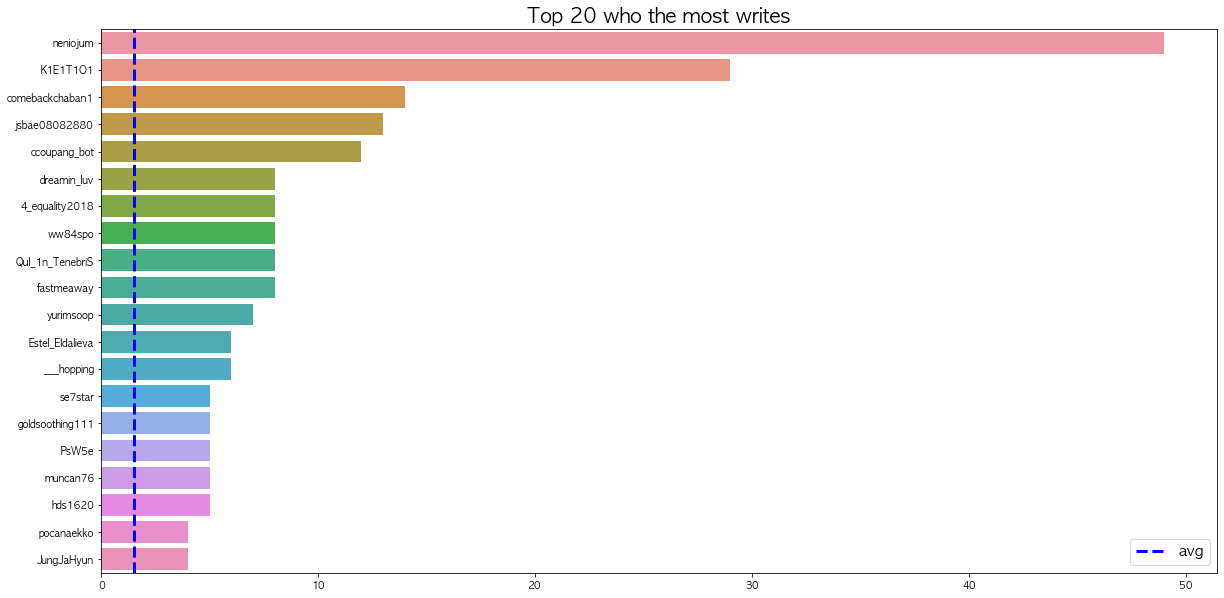

In [13]:
# 어떤 유저가 가장 많이 트윗을 썻는지
plt.figure(figsize=(20,10))
sns.barplot(x=women_policy['username'].value_counts()[:20].values, 
            y=women_policy['username'].value_counts()[:20].index,
           orient='h')
plt.title('Top 20 who the most writes', fontsize=20)
plt.axvline(x=np.average(women_policy['username'].value_counts().values), color='b', linestyle='--', linewidth=3, 
            label='avg')
plt.legend(fontsize=15)
# save_fig('Top 20 who the most writes')

그림 저장: text length distribution


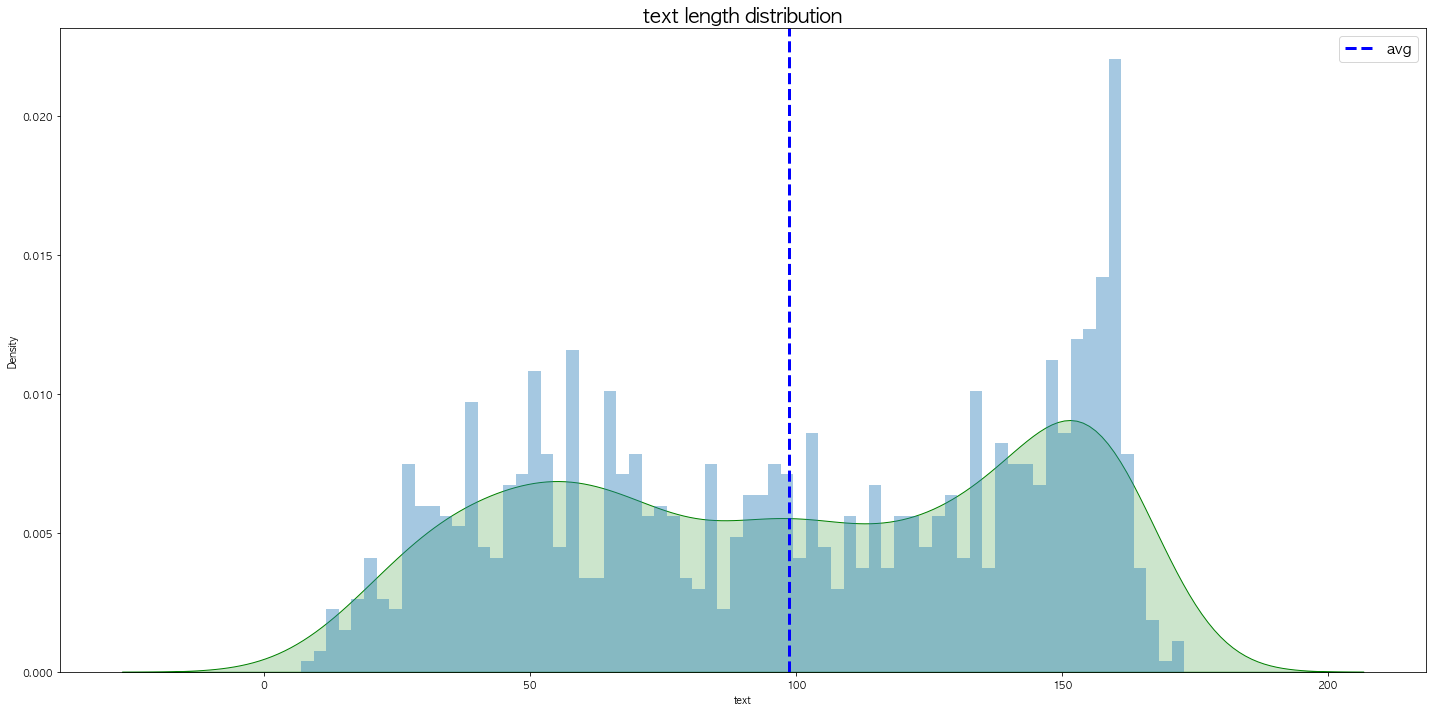

In [14]:
# 전체 문장 길이 분포
plt.figure(figsize=(20,10))
sns.distplot(a=women_policy['text'].str.lefn(), bins=70, kde=True,
             kde_kws={"color":"g", "alpha":0.2, "linewidth":1, "shade":True})
plt.title('text length distribution', fontsize=20)
plt.axvline(x=np.average(women_policy['text'].str.len()), color='b', linestyle='--', linewidth=3, 
            label='avg')
plt.legend(fontsize=15)
save_fig('text length distribution')

In [15]:
# tokenizer
kkma = Kkma()
komoran = Komoran()
okt = Okt()
mecab = Mecab()

# stopwords list
stop_words = pd.read_csv('dataset/한국어불용어100.txt', sep = "\t", engine='python')
stop_words = list(stop_words["word"])

In [16]:
def common_words(words, k):
    c = Counter(words)
    cw = c.most_common(k)
    return c, cw

In [17]:
def tokenizing(df, tokenizer):
    nouns = df.swifter.apply(lambda x : tokenizer.nouns(x))
    nouns_list = np.concatenate(nouns.tolist()).tolist()
    words = [n for n in nouns_list if len(n) > 1] 
    return nouns_list, words

In [203]:
def stopwords(words, stop_words):
    words_new = []

    for word in words:
        if word not in stop_words:
            words_new.append(word)
    return words_new

In [19]:
def wordcloud(c):
    wc = WordCloud(font_path='Arial Unicode', width=2000, height=1200, background_color ='white', scale=2.0, max_font_size=250)
    gen = wc.generate_from_frequencies(c)
    plt.figure(figsize = (12, 6), facecolor = None) 
    plt.imshow(gen)
    plt.axis("off")
    plt.tight_layout(pad=0)
    # save_fig("most_common_words_wordcloud")

In [184]:
# wordcloud
nouns_list, words = tokenizing(women_policy['text'], okt)
words_new = stopwords(words, stop_words)
c, cw = common_words(words_new, 200)
wordcloud(c)
save_fig('wordcloud')

TypeError: 'list' object is not callable

In [21]:
cw

[('정책', 1458),
 ('여성', 1068),
 ('이재명', 457),
 ('윤석열', 248),
 ('후보', 238),
 ('사람', 184),
 ('민주당', 149),
 ('공약', 149),
 ('생각', 143),
 ('여자', 138),
 ('투표', 126),
 ('여가부', 103),
 ('대선', 95),
 ('진짜', 93),
 ('폐지', 89),
 ('대통령', 83),
 ('이준석', 75),
 ('심상정', 66),
 ('얘기', 65),
 ('지지', 64),
 ('당선', 62),
 ('보고', 59),
 ('페미', 59),
 ('가족', 59),
 ('토론', 59),
 ('한국', 56),
 ('선거', 53),
 ('관련', 52),
 ('대해', 51),
 ('남자', 50),
 ('정치', 49),
 ('이번', 47),
 ('노동', 45),
 ('그냥', 45),
 ('문제', 45),
 ('전략', 44),
 ('대표', 44),
 ('페미니즘', 42),
 ('정부', 39),
 ('사회', 39),
 ('박지현', 39),
 ('정의당', 39),
 ('정당', 38),
 ('홍보', 37),
 ('위해', 37),
 ('지지율', 36),
 ('관심', 35),
 ('국힘', 35),
 ('출산', 35),
 ('페미니스트', 34),
 ('존나', 32),
 ('신경', 32),
 ('여성인권', 32),
 ('남성', 32),
 ('성범죄', 32),
 ('청소년', 31),
 ('의원', 31),
 ('이유', 31),
 ('여혐', 31),
 ('무슨', 31),
 ('인간', 31),
 ('임신', 31),
 ('발언', 30),
 ('그게', 30),
 ('임금', 30),
 ('이행', 30),
 ('개인', 29),
 ('자기', 29),
 ('문재인', 28),
 ('성폭력', 28),
 ('제대로', 27),
 ('지원', 27),
 ('눈치', 27),
 ('육아', 27),
 (

In [22]:
c

Counter({'대통령': 83,
         '가장': 25,
         '발언': 30,
         '각하': 1,
         '충성': 3,
         '민주당': 149,
         '여성': 1068,
         '정책': 1458,
         '노동': 45,
         '환경': 15,
         '홍보': 37,
         '영업': 9,
         '문재인': 28,
         '사랑': 1,
         '존경': 1,
         '지지': 64,
         '이재명': 457,
         '존나': 32,
         '사람': 184,
         '어쩌': 7,
         '진짜': 93,
         '제대로': 27,
         '지난': 13,
         '대선': 95,
         '관련': 52,
         '혼자': 14,
         '몰입': 2,
         '언제': 8,
         '피해자': 26,
         '언급': 9,
         '사과': 20,
         '이제': 24,
         '살인자': 1,
         '허울': 1,
         '이쯤': 1,
         '이면': 8,
         '보확': 3,
         '조작': 9,
         '그냥': 45,
         '원래': 9,
         '추종자': 1,
         '남성연대': 8,
         '하등': 1,
         '공식': 2,
         '직위': 1,
         '안철수': 16,
         '양심': 6,
         '신지': 8,
         '여가부': 103,
         '폐지': 89,
         '빈대': 1,
         '초가삼간': 1,
         '젠더': 

In [23]:
# tokenizing preprocessing
# okt noun 
nouns = women_policy['text'].swifter.apply(lambda x : okt.nouns(x))

Pandas Apply:   0%|          | 0/1128 [00:00<?, ?it/s]

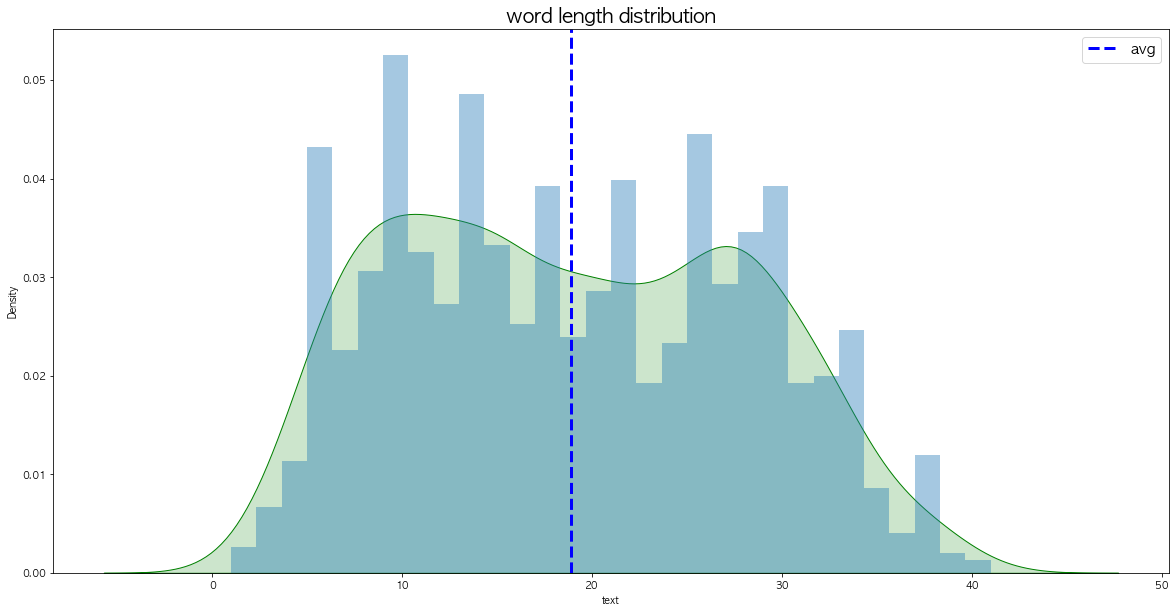

In [24]:
# 단어 길이 분포
plt.figure(figsize=(20,10))
sns.distplot(a=nouns.str.len(), bins=30, kde=True,
             kde_kws={"color":"g", "alpha":0.2, "linewidth":1, "shade":True})
plt.title('word length distribution', fontsize=20)
plt.axvline(x=nouns.str.len().mean(), color='b', linestyle='--', linewidth=3, 
            label='avg')
plt.legend(fontsize=15)
# save_fig('word length distribution')

In [202]:
# stopword 단어 분포
def only_stopwords(words, stop_words):
    words_new = []

    for word in words:
        if word in stop_words:
            words_new.append(word)
    return words_new

In [30]:
words_new = stopwords(words, stop_words)

No handles with labels found to put in legend.


그림 저장: stopword distribution


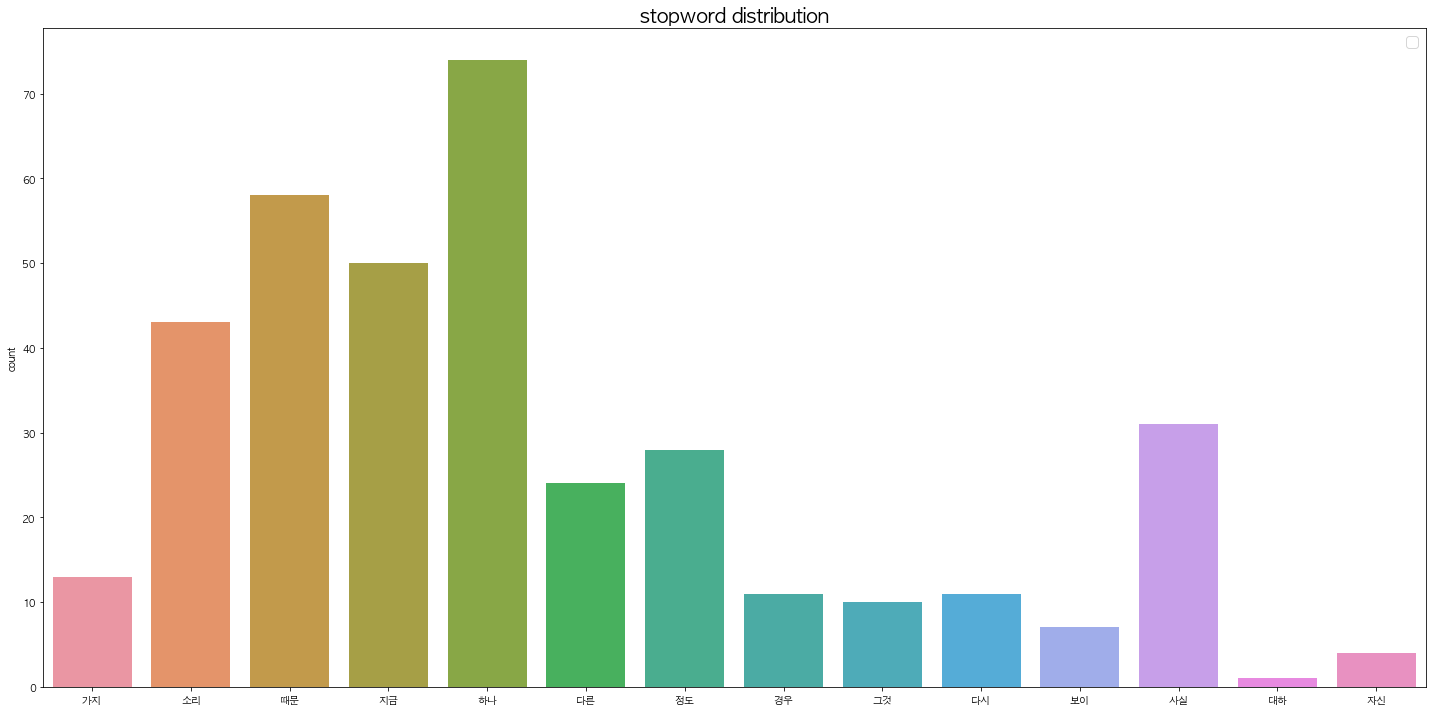

In [31]:
plt.figure(figsize=(20,10))
sns.countplot(words_new)
plt.title('stopword distribution', fontsize=20)
plt.legend(fontsize=15)
save_fig('stopword distribution')

In [32]:
# ngram exploration
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

In [33]:
new = women_policy['text'].str.split()
new = new.values.tolist()

In [34]:
words = [n for n in new if len(n) > 1] 

In [35]:
corpus = sum(words, [])

In [36]:
vec = CountVectorizer(ngram_range=(2,2)).fit(corpus)

In [37]:
bag_of_words = vec.transform(corpus)

In [38]:
sum_words = bag_of_words.sum(axis=0) 

In [39]:
words_freq = [(word, sum_words[0, idx])  for word, idx in vec.vocabulary_.items()]

In [40]:
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

In [41]:
top_n_bigrams = words_freq[:10]

In [42]:
x,y=map(list,zip(*top_n_bigrams))

No handles with labels found to put in legend.


그림 저장: ngram exploration


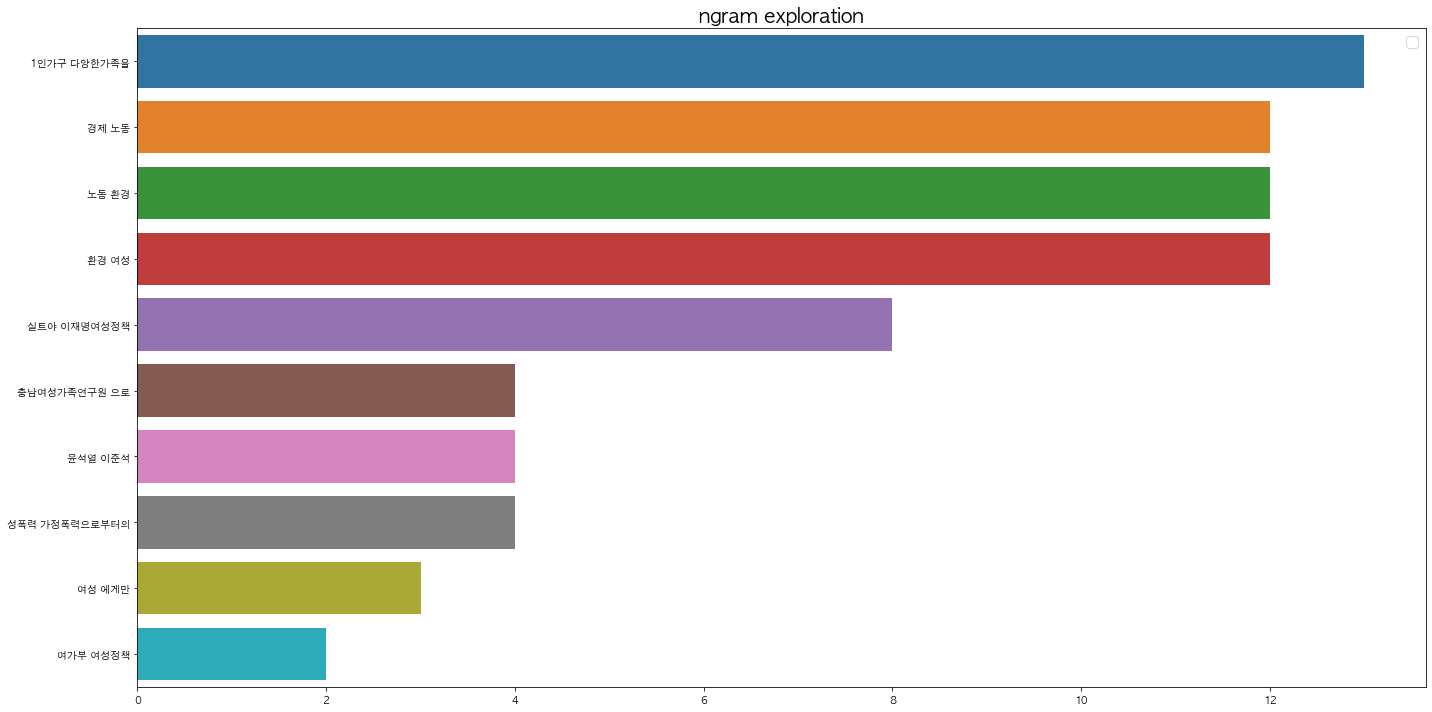

In [43]:
plt.figure(figsize=(20,10))
sns.barplot(x=y,y=x)
plt.title('ngram exploration', fontsize=20)
plt.legend(fontsize=15)
save_fig("ngram exploration")

In [44]:
nouns = women_policy['text'].swifter.apply(lambda x : okt.nouns(x))

Pandas Apply:   0%|          | 0/1128 [00:00<?, ?it/s]

In [45]:
women_policy['tokenizing'] = nouns

In [46]:
women_policy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128 entries, 0 to 1127
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    1128 non-null   object 
 1   id          1128 non-null   int64  
 2   text        1128 non-null   object 
 3   username    1128 non-null   object 
 4   tokenized   1128 non-null   object 
 5   label       1128 non-null   object 
 6   score       1128 non-null   float64
 7   label_word  1128 non-null   object 
 8   tokenizing  1128 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 120.4+ KB


In [47]:
women_policy['datetime']

0       2022-02-10 01:57:58+00:00
1       2022-02-10 03:03:04+00:00
2       2022-02-10 03:06:08+00:00
3       2022-02-10 05:03:53+00:00
4       2022-02-10 07:20:30+00:00
                  ...            
1123    2022-03-08 16:33:58+00:00
1124    2022-03-08 16:57:04+00:00
1125    2022-03-08 22:16:05+00:00
1126    2022-03-08 22:25:14+00:00
1127    2022-03-08 23:56:01+00:00
Name: datetime, Length: 1128, dtype: object

In [48]:
women_policy['date'] = pd.to_datetime(women_policy['datetime']).apply(lambda x: x.date())

In [49]:
women_policy['date_re'] = women_policy['date'].apply(lambda x : x.strftime('%Y-%m-%d'))

In [50]:
date = []
word_list = []
count_list = []
# tokenizing_list = []

for i in women_policy['date_re'].unique():
    tokenizing = sum(women_policy[women_policy['date_re'] == i]['tokenizing'],[])
    c, cw = common_words(tokenizing, 1)    
    word = cw[0][0]
    count = cw[0][1]
    date.append(i)
    word_list.append(word)
    count_list.append(count)
    
dateworddict = {'date' : date, 'word' : word_list, 'count' : count_list}
test_df = pd.DataFrame(dateworddict, columns=['date', 'word', 'count'])

In [49]:
# dateworddict = {'date' : date, 'word' : word_list, 'count' : count_list}
# test_df = pd.DataFrame(dateworddict, columns=['date', 'word', 'count'])

In [51]:
def add_value_labels(ax, spacing=5):
    for idx, rect in enumerate(ax.patches):
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -1
            va = 'top'

        label = "{0}".format(test_df['word'][idx])

        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)  

No handles with labels found to put in legend.


그림 저장: most common word by date


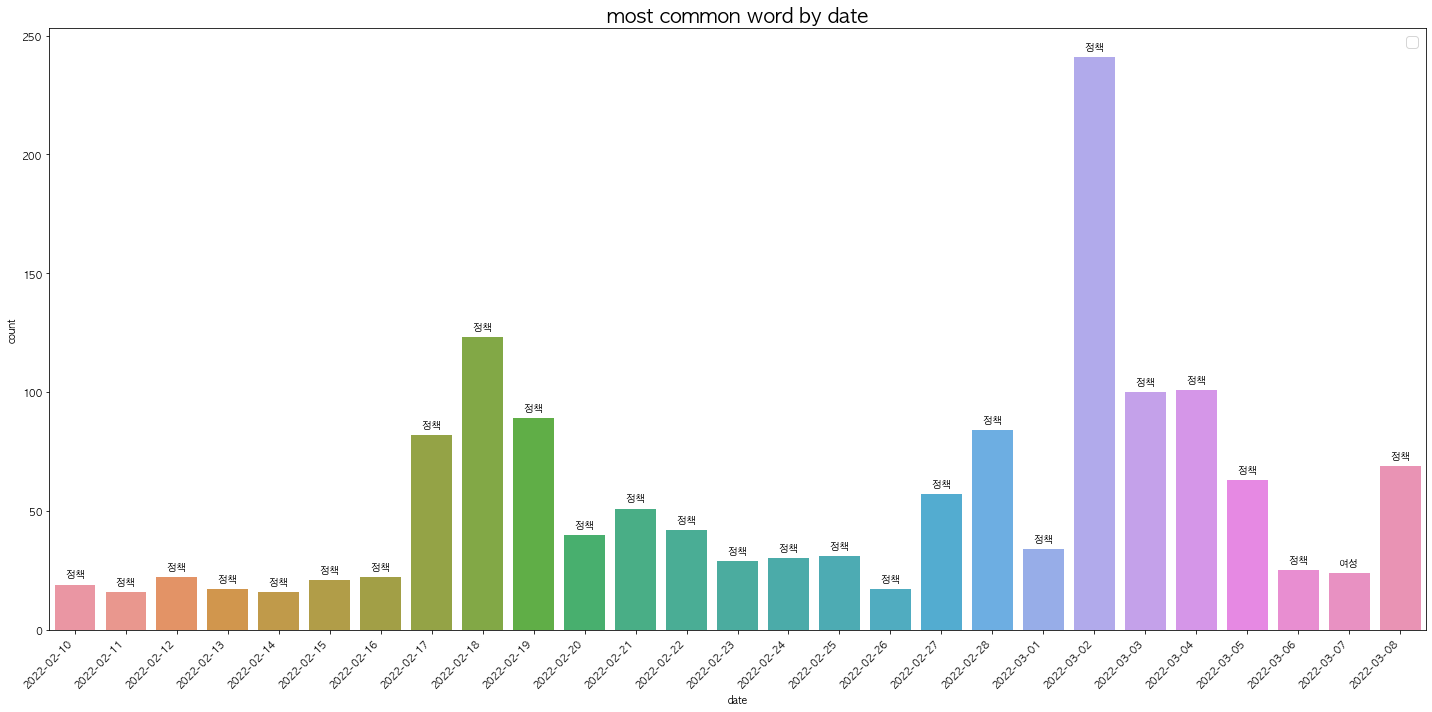

In [52]:
fig, ax = plt.subplots(1, figsize=(20,10))
plot = sns.barplot(test_df['date'], test_df['count'])
add_value_labels(ax)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('most common word by date', fontsize=20)
plt.legend(fontsize=15)
save_fig("most common word by date")

# 감성 분석

In [84]:
women_policy['text_len'] = women_policy['text'].str.len()

In [85]:
women_policy_p = women_policy[women_policy['label_word'] == 'P']
women_policy_n = women_policy[women_policy['label_word'] == 'N']

<AxesSubplot:xlabel='text_len'>

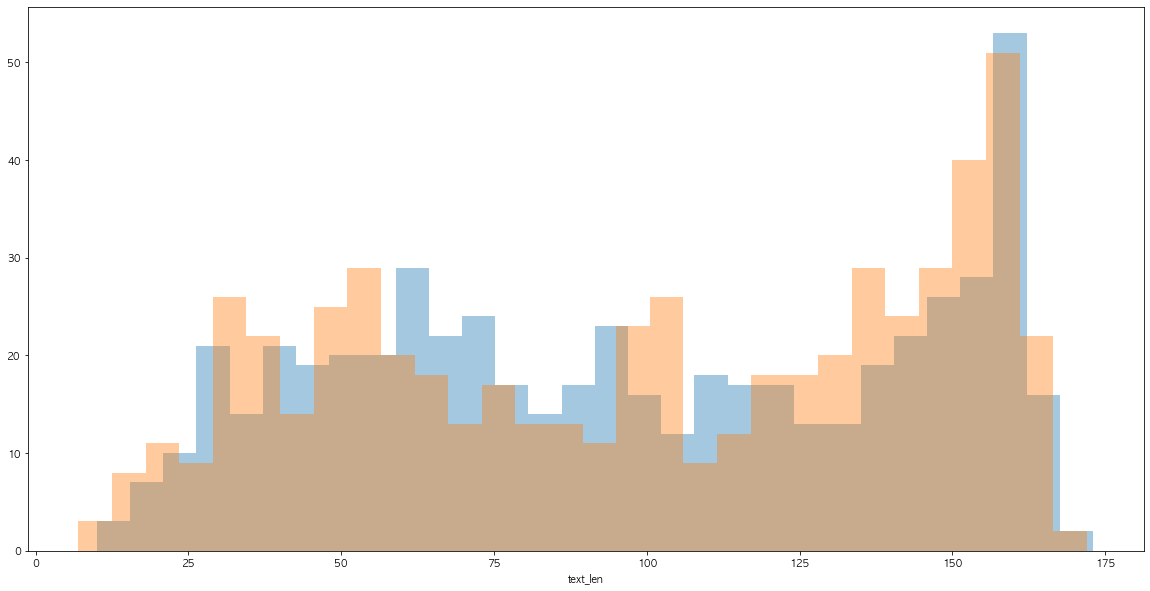

In [103]:
# 긍부정 문장 길이
plt.figure(figsize=(20,10))
sns.distplot(women_policy_p['text_len'], bins=30,
             kde=False,
             rug_kws={"color": "r", "alpha": 0.3, "linewidth": 2, "height":0.2})
sns.distplot(women_policy_n['text_len'], bins=30,
             kde=False,
             rug_kws={"color": "r", "alpha": 0.3, "linewidth": 2, "height":0.2})

In [181]:
sum(women_policy_p['tokenizing'], [])

['대통령',
 '가장',
 '발언',
 '각하',
 '충성',
 '충성',
 '충성',
 '민주당',
 '여성',
 '정책',
 '노동',
 '정책',
 '환경',
 '정책',
 '홍보',
 '또',
 '영업',
 '슴',
 '문재인',
 '사랑',
 '존경',
 '대통령',
 '지지',
 '이재명',
 '존나',
 '사람',
 '어쩌',
 '거',
 '진짜',
 '여성',
 '정책',
 '가지',
 '거',
 '제대로',
 '지난',
 '대선',
 '관련',
 '이재명',
 '못',
 '사람',
 '혼자',
 '과',
 '몰입',
 '여가부',
 '폐지',
 '말',
 '빈대',
 '초가삼간',
 '소리',
 '바',
 '여가부',
 '여성',
 '정책',
 '젠더',
 '갈등',
 '원인',
 '기도',
 '청소년',
 '복지',
 '정책',
 '등',
 '일도',
 '때문',
 '완전',
 '폐지',
 '개혁',
 '여성',
 '모두',
 '정부',
 '부처',
 '수',
 '진짜',
 '전략',
 '투표',
 '저',
 '사람',
 '정책',
 '문제',
 '평등',
 '남성연대',
 '사람',
 '여성',
 '연예인',
 '성희롱',
 '가정폭력',
 '전과',
 '낙태죄',
 '시위',
 '조롱',
 '등',
 '정책',
 '신경',
 '게',
 '오히려',
 '여성인권',
 '트리',
 '사람',
 '국민',
 '힘',
 '대변인',
 '준우',
 '놈',
 '글',
 '좀',
 '국힘',
 '놈',
 '권력',
 '정부',
 '각',
 '분야',
 '침투',
 '여성',
 '정책',
 '망가뜨릴',
 '준비',
 '제발',
 '윤석열',
 '탈레반',
 '이',
 '나라',
 '혐',
 '국가',
 '전략',
 '투표',
 '가부장제',
 '분명',
 '게',
 '개인',
 '여성연대',
 '비혼',
 '비',
 '출산',
 '형태',
 '표',
 '수도',
 '정책',
 '지지',
 '등',
 '방향',
 '길이',
 '불구',
 '기혼',


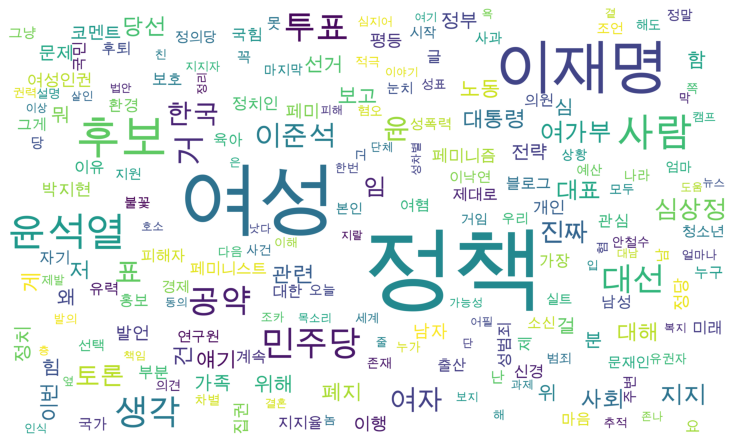

In [211]:
# 긍정
words = [n for n in women_policy_p['tokenizing'] if len(n) > 1] 
words = sum(words, [])
words_new = stopwords(words, stop_words)
c, cw = common_words(words_new, 200)
wordcloud(c)

In [212]:
cw

[('정책', 722),
 ('여성', 526),
 ('이재명', 251),
 ('후보', 149),
 ('윤석열', 105),
 ('사람', 103),
 ('생각', 79),
 ('민주당', 77),
 ('투표', 72),
 ('공약', 70),
 ('대선', 67),
 ('거', 65),
 ('윤', 51),
 ('표', 49),
 ('이준석', 49),
 ('여자', 48),
 ('한국', 47),
 ('진짜', 41),
 ('토론', 41),
 ('심상정', 40),
 ('여가부', 39),
 ('지지', 37),
 ('임', 35),
 ('대표', 35),
 ('당선', 32),
 ('사회', 32),
 ('게', 31),
 ('대통령', 30),
 ('관련', 30),
 ('건', 30),
 ('대해', 30),
 ('노동', 29),
 ('저', 29),
 ('폐지', 28),
 ('얘기', 28),
 ('함', 27),
 ('보고', 27),
 ('위해', 26),
 ('이번', 26),
 ('심', 25),
 ('선거', 25),
 ('정부', 24),
 ('힘', 24),
 ('뭐', 24),
 ('위', 24),
 ('가족', 24),
 ('왜', 24),
 ('전략', 23),
 ('분', 23),
 ('정치', 23),
 ('걸', 23),
 ('문제', 21),
 ('남자', 21),
 ('발언', 19),
 ('정당', 19),
 ('페미', 19),
 ('이행', 19),
 ('코멘트', 19),
 ('평등', 18),
 ('집권', 18),
 ('박지현', 18),
 ('여성인권', 17),
 ('개인', 17),
 ('페미니즘', 17),
 ('가장', 16),
 ('글', 15),
 ('국힘', 15),
 ('정치인', 15),
 ('페미니스트', 15),
 ('계속', 15),
 ('성범죄', 15),
 ('이유', 15),
 ('관심', 15),
 ('자기', 15),
 ('부분', 15),
 ('대한', 15),
 ('환

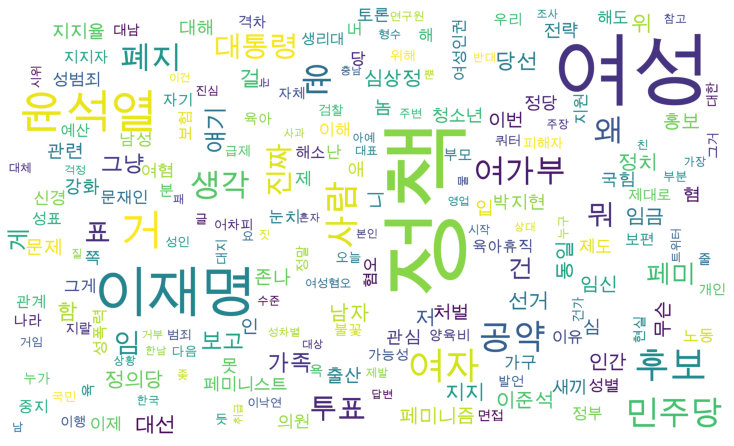

In [209]:
# 부정
words = [n for n in women_policy_n['tokenizing'] if len(n) > 1] 
words = sum(words, [])
words_new = stopwords(words, stop_words)
c, cw = common_words(words_new, 200)
wordcloud(c)

In [210]:
cw

[('정책', 735),
 ('여성', 542),
 ('이재명', 206),
 ('윤석열', 143),
 ('거', 115),
 ('여자', 90),
 ('후보', 89),
 ('사람', 81),
 ('공약', 79),
 ('윤', 76),
 ('민주당', 72),
 ('생각', 64),
 ('여가부', 64),
 ('폐지', 61),
 ('왜', 58),
 ('투표', 54),
 ('대통령', 53),
 ('진짜', 52),
 ('뭐', 51),
 ('임', 48),
 ('표', 47),
 ('페미', 40),
 ('게', 38),
 ('건', 38),
 ('얘기', 37),
 ('가족', 35),
 ('그냥', 33),
 ('보고', 32),
 ('함', 32),
 ('위', 30),
 ('당선', 30),
 ('걸', 29),
 ('남자', 29),
 ('선거', 28),
 ('대선', 28),
 ('임금', 27),
 ('지지', 27),
 ('정의당', 27),
 ('저', 26),
 ('심상정', 26),
 ('인간', 26),
 ('동일', 26),
 ('이준석', 26),
 ('정치', 26),
 ('페미니즘', 25),
 ('무슨', 24),
 ('존나', 24),
 ('홍보', 24),
 ('임신', 24),
 ('문제', 24),
 ('놈', 23),
 ('입', 23),
 ('심', 22),
 ('니', 22),
 ('지지율', 22),
 ('강화', 22),
 ('출산', 22),
 ('관련', 22),
 ('대해', 21),
 ('전략', 21),
 ('이번', 21),
 ('인', 21),
 ('처벌', 21),
 ('박지현', 21),
 ('애', 21),
 ('관심', 20),
 ('국힘', 20),
 ('못', 20),
 ('새끼', 20),
 ('혐', 20),
 ('청소년', 19),
 ('정당', 19),
 ('제', 19),
 ('페미니스트', 19),
 ('의원', 18),
 ('신경', 18),
 ('여혐', 18),

In [52]:
# topic modeling exploration with pyLDAvis

In [53]:
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim_models

In [54]:
corpus = []
stem = PorterStemmer()
lem = WordNetLemmatizer()
for news in text :
    words = [w for w in word_to]

/Users/sol/miniforge3/envs/m1/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'text' is not defined

In [55]:
nouns.str.len().mean()

/Users/sol/miniforge3/envs/m1/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


18.89627659574468

In [ ]:
def plot_word_number_histogram(text):
    text.str.split().map(lambda x: len(x)).hist()

In [ ]:
mecab.nouns(women_policy['text'][0])

In [ ]:
nouns = women_policy['text'].swifter.apply(lambda x : mecab.nouns(x))

In [ ]:
words_new = stopwords(words, stop_words)

In [ ]:
c, cw = common_words(words_new, 200)

In [ ]:
wordcloud(c)

In [ ]:
np.concatenate(women_policy['text'].tolist()).tolist()

In [ ]:
women_policy['text'].tolist()

In [ ]:
women_policy['text'].swifter.apply(lambda x : komoran.nouns(x))

In [ ]:
len(women_policy['text'])

In [ ]:
word_list = []
for i in range(len(women_policy['text'])):
    word = mecab.nouns(women_policy['text'][i])
    word_list.append(word)

In [ ]:
word_list = []
for i in range(15):
    word = komoran.nouns(women_policy['text'][i])
    word_list.append(word)

In [ ]:
new_word_list = np.concatenate(word_list).tolist()

In [ ]:
words = [n for n in new_word_list if len(n) > 1] 

In [ ]:
words

In [ ]:
words_new = stopwords(words, stop_words)

In [ ]:
words_new

In [ ]:
c, cw = common_words(words_new, 200)

In [ ]:
= np.concatenate(word_list).tolist()

In [ ]:
len(women_policy['text'])

In [ ]:
word = komoran.nouns(women_policy['text'][0])
word

In [ ]:
women_policy['text'][0]

In [ ]:
komoran.pos(women_policy['text'].tolist())